<!--
 * @Author: TMJ
 * @Date: 2023-12-31 16:40:56
 * @LastEditors: TMJ
 * @LastEditTime: 2024-01-10 18:38:24
 * @Description: 请填写简介
-->
# MolOP Tutorial

MolOP supports 4 common cheminformatic file formats now:
- Coords file
  - GJF
  - XYZ
  - SDF
- QM output file
  - G16 LOG
  - G16 IRC
  - G16 FCHK
  - xTB OUT

All of them support the basic functions that:
- Recognize the molecule and give **standardized SMILES**
- Extract the geometry
- Extract the charge and multiplicity (XYZ file should be user given)
- Provide **RDKit molecule object / OpenBabel molecule object** with 3D coordinates
- Support multi-frame molecule in one file
- All physical properties are combined with explicit units provided by [pint](https://pint.readthedocs.io/en/stable/index.html), witch can be easily transformed to other units

For G16 LOG file (and other QM output files future), it also supports:
- Extract the **energy** (and thermal Energies/Enthalpies/Free Energies/zero-point Energies with correction or not), with unit Hartree/Particle
- Extract the **partial charges** (Mulliken charges)
- Extract the **gradient**, with unit Hartree/Bhor
- Extract the **orbitals energies** (alpha, beta) and HOMO/LUMO, with unit Hartree/Particle
- Extract the **frequencies** with Reduced masses, force constants, IR intensities, normal coordinates and check if it is **imaginary**
- Extract the **Hessian** stored in a flatten lower triangular portion
- All frame in the optimalization will be processed by steps above, **not only the last frame**

## Get Start

In [1]:
from molop import AutoParser
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400, 400

### Batch process

MolOP offer batch process functions. You can pass a path string to read all available files in this directory, then you can access the file parsers like list.

The read process is automatically parallelized using all cores.

In [2]:
files = AutoParser("../tests/test_files/mix_format")  # give a folder path
files.to_summary_excel()  # show basic infos

MolOP parsing with 28 jobs: 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
../tests/test_files/mix_format: 0 files failed to parse, 9 successfully parsed
/home/tmj/miniconda3/envs/molop/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1594: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [3]:
files[0]  # access file parser like list

G16FCHKParser(G16FCHKParser(dsgdb9nsd_000007-6.fchk))

The batch object can transform all files into coords files (.xyz, .sdf and .gjf)

In [4]:
# If file_path is not given, files will be generated in situ
files.to_XYZ_file(file_path="../tests/test_files/temp")
# If file_path is not given, files will be generated in situ
files.to_SDF_file(file_path="../tests/test_files/temp")
files.to_GJF_file(
    file_path="../tests/test_files/temp",
    prefix="""# some parameters""",
    suffix="""some basis""",
)  # fill the prefix and suffix, then generate new gjf parameters with old coords

In [5]:
# If file_path is not given, files will be generated in situ
files.to_chemdraw(file_path="../tests/test_files/temp")

New .gjf file example:

Use code below can create csv table with informations above

In [6]:
files.to_summary_csv(
    file_path=None
)  # if file_path not given, summary will be created in situ

Replace substituents in batches

In [7]:
# If bond_idx given, will try to replace the legal substituent binding to bond_idx
new_blocks = files.replace_substituent("[H]", "[C](C)(C)C", bind_idx=None)

100%|██████████| 9/9 [00:00<00:00, 139.15it/s]
9 files successfully replaced, 0 files failed to replace


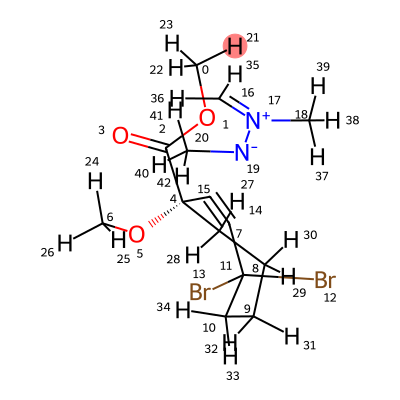

In [8]:
files[1][-1].rdmol

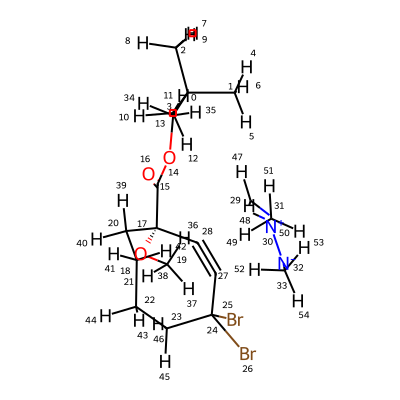

In [9]:
new_blocks[1].rdmol

Reset atom index in batches

MolOP parsing with 28 jobs: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
../tests/test_files/test_reset_index: 0 files failed to parse, 4 successfully parsed


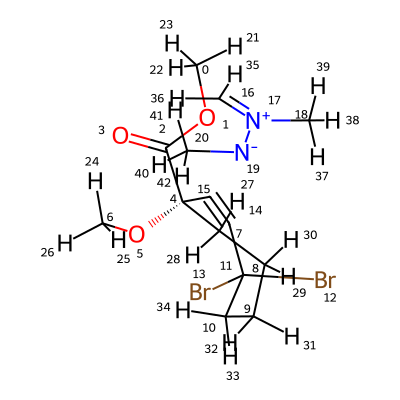

In [10]:
files = AutoParser("../tests/test_files/test_reset_index")
files[0][-1].rdmol

100%|██████████| 4/4 [00:00<00:00, 82.95it/s]
4 files successfully replaced, 0 files failed to reset_index


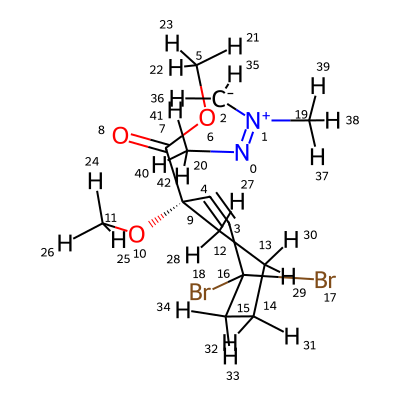

In [11]:
new_blocks = files.reset_atom_index(
    "[*^1,*^2]~[*+1^1,*+1^2]~[*+0^1,*+0^2].[C]#[C]")
new_blocks[0].rdmol

### Single file process

#### XYZ file TS with Metal and Radical

frame num: 1; atom num: 64
SMILES: CC(C)(C1=NCCO1)C1=NCCO1.C[C](C)N(C)C.[Cl-].[Cu+]c1ccc2ccccc2c1


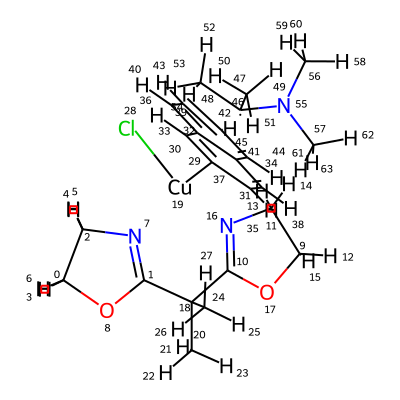

In [12]:
from molop import AutoParser

test_xyz_file = AutoParser("../tests/test_files/xyz/test.xyz", charge=0, multiplicity=3)
print(f"frame num: {len(test_xyz_file)}; atom num: {len(test_xyz_file[0])}")
print(f"SMILES: {test_xyz_file[0].to_standard_SMILES()}")
test_xyz_file[0].rdmol

#### G16 LOG with Single Point

frame num: 1; atom num: 33
SMILES: CCC[C@H]1CO[C@H]2C[C@@](C)(O)C[C@@H]12
parameter comment: 
 %nprocshared=32
 Will use up to   32 processors via shared memory.
 %mem=100GB
 # def2tzvp m06l


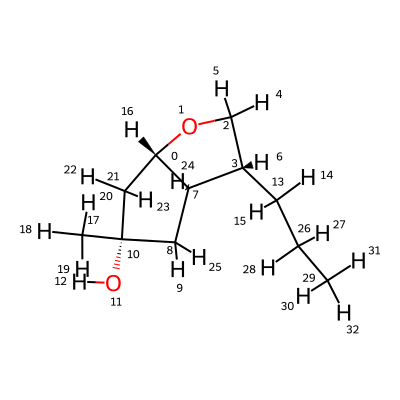

In [13]:
test_sp_file = AutoParser("../tests/test_files/g16log/3_Sp.log")
print(f"frame num: {len(test_sp_file)}; atom num: {len(test_sp_file[0])}")
print(f"SMILES: {test_sp_file[0].to_standard_SMILES()}")
print(f"parameter comment: \n{test_sp_file[0].parameter_comment}")
test_sp_file[0].rdmol

In [14]:
print(test_sp_file[0].energy)
test_sp_file[0].sum_energy

-581.780923 hartree / particle


{'zero-point': None,
 'thermal energy': None,
 'thermal enthalpy': None,
 'thermal gibbs free energy': None,
 'zero-point correction': None,
 'thermal energy correction': None,
 'thermal enthalpy correction': None,
 'thermal gibbs free energy correction': None}

In [15]:
print(f"partial charges num: {len(test_sp_file[0].partial_charges)}")
print(f"first 5: {test_sp_file[0].partial_charges[:5]}")

partial charges num: 33
first 5: [0.139353, -0.485914, 0.185647, 0.20812, 0.028079]


In [16]:
print(f"No freq No grdient: {test_sp_file[0].gradients}")

No freq No grdient: []


In [17]:
print(f"No freq parameter No freq: {test_sp_file[0].imaginary_frequencies}")
print(f"No freq parameter No freq: {test_sp_file[0].frequencies}")

No freq parameter No freq: []
No freq parameter No freq: []


In [18]:
print(test_sp_file[0].alpha_energy)
print(test_sp_file[0].beta_energy)

{'gap': <Quantity(0.24174, 'hartree / particle')>, 'homo': <Quantity(-0.21593, 'hartree / particle')>, 'lumo': <Quantity(0.02581, 'hartree / particle')>}
{'gap': None, 'homo': None, 'lumo': None}


In [19]:
print(f"No optimization No hessian: {test_sp_file[0].hessian}")

No optimization No hessian: []


#### G16 LOG with Opt

frame num: 13; atom num: 31
SMILES: C=C[C@H]1[C@@H]2[C@H](C[C@@]1(C)O)OC[C@@H]2C
parameter comment: 
 %nprocshared=32
 Will use up to   32 processors via shared memory.
 %mem=100GB
 # opt=maxcycle=150 freq def2svp m06l


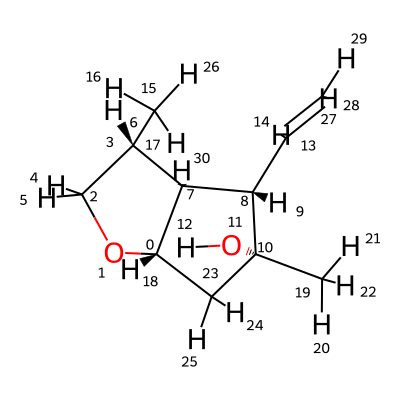

In [20]:
test_opt_file = AutoParser("../tests/test_files/g16log/11_Opt.log")
print(f"frame num: {len(test_opt_file)}; atom num: {len(test_opt_file[-1])}")
print(f"SMILES: {test_opt_file[-1].to_standard_SMILES()}")
print(f"parameter comment: \n{test_opt_file[-1].parameter_comment}")
test_opt_file[-1].rdmol

In [21]:
print(test_opt_file[-1].energy)
test_opt_file[-1].sum_energy

-579.925317 hartree / particle


{'zero-point': -579.649732 <Unit('hartree / particle')>,
 'thermal energy': -579.637414 <Unit('hartree / particle')>,
 'thermal enthalpy': -579.63647 <Unit('hartree / particle')>,
 'thermal gibbs free energy': -579.686912 <Unit('hartree / particle')>,
 'zero-point correction': 0.275585 <Unit('hartree / particle')>,
 'thermal energy correction': 0.287903 <Unit('hartree / particle')>,
 'thermal enthalpy correction': 0.288847 <Unit('hartree / particle')>,
 'thermal gibbs free energy correction': 0.238406 <Unit('hartree / particle')>}

In [22]:
print(f"partial charges num: {len(test_opt_file[-1].partial_charges)}")
print(f"first 5: {test_opt_file[-1].partial_charges[:5]}")

partial charges num: 31
first 5: [0.147998, -0.480978, 0.248552, -0.175483, 0.041544]


In [23]:
print(f"first 2 grdients: {test_opt_file[-1].gradients[:2]}")

first 2 grdients: [(<Quantity(-2.113e-06, 'hartree / bohr')>, <Quantity(4.623e-06, 'hartree / bohr')>, <Quantity(-3.46e-06, 'hartree / bohr')>), (<Quantity(-4.571e-06, 'hartree / bohr')>, <Quantity(6.814e-06, 'hartree / bohr')>, <Quantity(2.587e-06, 'hartree / bohr')>)]


In [24]:
print(
    f"No TS No imaginary frequencies: {test_opt_file[-1].imaginary_frequencies}")

print(f"first 1 freq: {test_opt_file[-1].frequencies[:1]}")

No TS No imaginary frequencies: []
first 1 freq: [{'freq': <Quantity(76.85, 'reciprocal_centimeter')>, 'is imaginary': False, 'Reduced masses': <Quantity(3.0435, 'unified_atomic_mass_unit')>, 'force constants': <Quantity(0.0106, 'millidyne / angstrom')>, 'IR intensities': <Quantity(0.26, 'kilomole / mole')>, 'normal coordinates': [(<Quantity(-0.01, 'angstrom')>, <Quantity(0.01, 'angstrom')>, <Quantity(-0.01, 'angstrom')>), (<Quantity(0.02, 'angstrom')>, <Quantity(0.04, 'angstrom')>, <Quantity(-0.04, 'angstrom')>), (<Quantity(-0.03, 'angstrom')>, <Quantity(0.07, 'angstrom')>, <Quantity(-0.06, 'angstrom')>), (<Quantity(-0.09, 'angstrom')>, <Quantity(0.02, 'angstrom')>, <Quantity(0.01, 'angstrom')>), (<Quantity(0.01, 'angstrom')>, <Quantity(0.08, 'angstrom')>, <Quantity(-0.09, 'angstrom')>), (<Quantity(-0.08, 'angstrom')>, <Quantity(0.1, 'angstrom')>, <Quantity(-0.1, 'angstrom')>), (<Quantity(-0.15, 'angstrom')>, <Quantity(0.07, 'angstrom')>, <Quantity(0.03, 'angstrom')>), (<Quantity(-0.0

In [25]:
print(test_opt_file[-1].alpha_energy)
print(test_opt_file[-1].beta_energy)

{'gap': <Quantity(0.20428, 'hartree / particle')>, 'homo': <Quantity(-0.2188, 'hartree / particle')>, 'lumo': <Quantity(-0.01452, 'hartree / particle')>}
{'gap': None, 'homo': None, 'lumo': None}


In [26]:
print(f"first 5 hessian: {test_opt_file[-1].hessian[:5]}")

first 5 hessian: [0.53872264, -0.02896982, 0.47221615, -0.09671196, -0.04707728]


#### G16 LOG with TS

frame num: 13; atom num: 47
SMILES: [Br-].[Br-].[Ni@OH26+3]c1ccccc1.[S-]Cc1ccccc1.c1c[nH]cn1.c1c[nH]cn1
parameter comment: 
 %nprocshared=32
 Will use up to   32 processors via shared memory.
 %mem=100GB
 # opt=(calcfc,ts,maxcycle=150,noeigen) freq ub3lyp/genecp empiricaldis
 persion=gd3bj


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is charge 0 multiplicity 1)



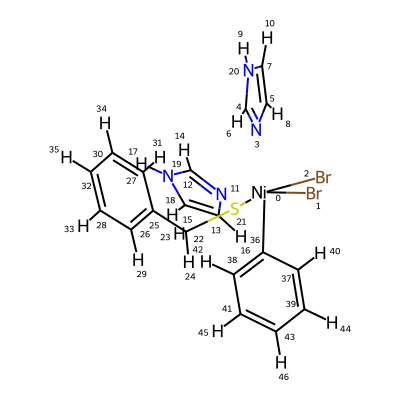

In [27]:
test_ts_file = AutoParser("../tests/test_files/g16log/S_Ph_Ni_TS.log")
print(f"frame num: {len(test_ts_file)}; atom num: {len(test_ts_file[-1])}")
print(f"SMILES: {test_ts_file[-1].to_standard_SMILES()}")
print(f"parameter comment: \n{test_ts_file[-1].parameter_comment}")
test_ts_file[-1].rdmol

In [28]:
print(test_ts_file[-1].energy)
test_ts_file[-1].sum_energy

-1549.05355 hartree / particle


{'zero-point': -1548.691989 <Unit('hartree / particle')>,
 'thermal energy': -1548.66487 <Unit('hartree / particle')>,
 'thermal enthalpy': -1548.663926 <Unit('hartree / particle')>,
 'thermal gibbs free energy': -1548.752428 <Unit('hartree / particle')>,
 'zero-point correction': 0.361561 <Unit('hartree / particle')>,
 'thermal energy correction': 0.38868 <Unit('hartree / particle')>,
 'thermal enthalpy correction': 0.389624 <Unit('hartree / particle')>,
 'thermal gibbs free energy correction': 0.301123 <Unit('hartree / particle')>}

In [29]:
print(f"partial charges num: {len(test_ts_file[-1].partial_charges)}")
print(f"first 5: {test_ts_file[-1].partial_charges[:5]}")

partial charges num: 47
first 5: [-0.275278, -0.2701, -0.195995, -0.374709, 0.238983]


In [30]:
print(f"first 2 grdients: {test_ts_file[-1].gradients[:2]}")

first 2 grdients: [(<Quantity(-2.53e-07, 'hartree / bohr')>, <Quantity(-3.125e-06, 'hartree / bohr')>, <Quantity(-6.649e-06, 'hartree / bohr')>), (<Quantity(5.86e-07, 'hartree / bohr')>, <Quantity(-1.071e-06, 'hartree / bohr')>, <Quantity(-5.85e-07, 'hartree / bohr')>)]


In [31]:
print(f"imaginary frequencies: {test_ts_file[-1].imaginary_frequencies}")
print(f"last 1 freq: {test_ts_file[-1].frequencies[-1:]}")

imaginary frequencies: [{'freq': <Quantity(-185.8656, 'reciprocal_centimeter')>, 'is imaginary': True, 'Reduced masses': <Quantity(8.7628, 'unified_atomic_mass_unit')>, 'force constants': <Quantity(0.1784, 'millidyne / angstrom')>, 'IR intensities': <Quantity(37.9609, 'kilomole / mole')>, 'normal coordinates': [(<Quantity(0.03, 'angstrom')>, <Quantity(0.07, 'angstrom')>, <Quantity(-0.07, 'angstrom')>), (<Quantity(0.01, 'angstrom')>, <Quantity(-0.01, 'angstrom')>, <Quantity(-0.01, 'angstrom')>), (<Quantity(-0.0, 'angstrom')>, <Quantity(0.01, 'angstrom')>, <Quantity(-0.0, 'angstrom')>), (<Quantity(-0.05, 'angstrom')>, <Quantity(0.07, 'angstrom')>, <Quantity(-0.01, 'angstrom')>), (<Quantity(-0.02, 'angstrom')>, <Quantity(0.06, 'angstrom')>, <Quantity(0.0, 'angstrom')>), (<Quantity(-0.03, 'angstrom')>, <Quantity(0.06, 'angstrom')>, <Quantity(-0.0, 'angstrom')>), (<Quantity(-0.01, 'angstrom')>, <Quantity(0.07, 'angstrom')>, <Quantity(0.01, 'angstrom')>), (<Quantity(-0.0, 'angstrom')>, <Quan

In [32]:
print(test_ts_file[-1].alpha_energy)
print(test_ts_file[-1].beta_energy)

{'gap': <Quantity(0.07788, 'hartree / particle')>, 'homo': <Quantity(-0.18821, 'hartree / particle')>, 'lumo': <Quantity(-0.11033, 'hartree / particle')>}
{'gap': <Quantity(0.07788, 'hartree / particle')>, 'homo': <Quantity(-0.18821, 'hartree / particle')>, 'lumo': <Quantity(-0.11033, 'hartree / particle')>}


In [33]:
print(f"first 5 hessian: {test_ts_file[-1].hessian[:5]}")

first 5 hessian: [0.17022137, 0.00364296, 0.11041035, -0.03350619, -0.01261719]
